# Uplift

### 00. data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('./data/hillstrom_clean.csv')

labels_mapping = {"control": 0, "womans_email": 1, "mens_email": 2}

- 해당 데이터는 experimental data이고 treatment는 3가지이다.
  - control 그룹, mens관련 상품 이메일을 받은 그룹, womans관련 상품 이메일을 받은 그룹

In [5]:
print(f'data.shape={data.shape}')

data.shape=(64000, 13)


In [3]:
data.head(3)

recency  history  mens  womens  newbie  visit  conversion  spend  \
0       10   142.44     1       0       0      0           0    0.0   
1        6   329.08     1       1       1      0           0    0.0   
2        7   180.65     0       1       1      0           0    0.0   

   zip_code__rural  zip_code__surburban  zip_code__urban  \
0                0                    1                0   
1                1                    0                0   
2                0                    1                0   

   channel__multichannel  channel__phone  channel__web  treatment  
0                      0               1             0          1  
1                      0               0             1          0  
2                      0               0             1          1

In [4]:
data = data.drop(['zip_code__urban', 'channel__web'], axis=1)

## 01. check randomization

In [6]:
data_X = data.drop(['visit', 'conversion', 'spend', 'treatment'], axis=1)
data_Y = data['spend']
data_T = data['treatment']

In [7]:
# treatment 비율
data_T.value_counts()

1    21387
2    21307
0    21306
Name: treatment, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train_eda, X_test_eda, T_train_eda, T_test_eda = train_test_split(data_X, data_T, test_size=.5)

In [11]:
from lightgbm import LGBMClassifier

In [12]:
lgbm_eda = LGBMClassifier()
lgbm_eda.fit(X_train_eda, T_train_eda)

LGBMClassifier()

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
T_pred_eda = lgbm_eda.predict(X_test_eda)
accuracy_score(T_test_eda, T_pred_eda)

0.33215625

- acc가 treatment의 비율과 비슷하다.
- 즉, feature들을 통해서 treatment을 맞출 수 없다. random이다.

In [16]:
import numpy as np

In [17]:
# empirical confidence

random_scores = []
test_eda_sample_size = T_test_eda.shape[0]

for _ in range(10000):
    random_scores.append(
        (np.random.choice([0, 1, 2], test_eda_sample_size) == np.random.choice([0, 1, 2], test_eda_sample_size)).mean())
np.quantile(random_scores, .025), np.quantile(random_scores, .975)

(0.328375, 0.3385)

In [3]:
train.head(3)

age  python_proficiency  took_a_course  earnings
0   23            0.632318           True  139267.0
1   20            0.602551          False  115569.0
2   21            0.518225          False  119142.0

In [4]:
test.head(3)

age  python_proficiency  took_a_course  true_effect
0   30            0.223877           True      11120.0
1   23            0.394152           True      11970.0
2   37            0.214638           True      11073.0

In [ ]:
data_T.value_counts()

### 01. graph

In [5]:
nodes = ['took_a_course', 'python_proficiency', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings'),
    ('python_proficiency', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'


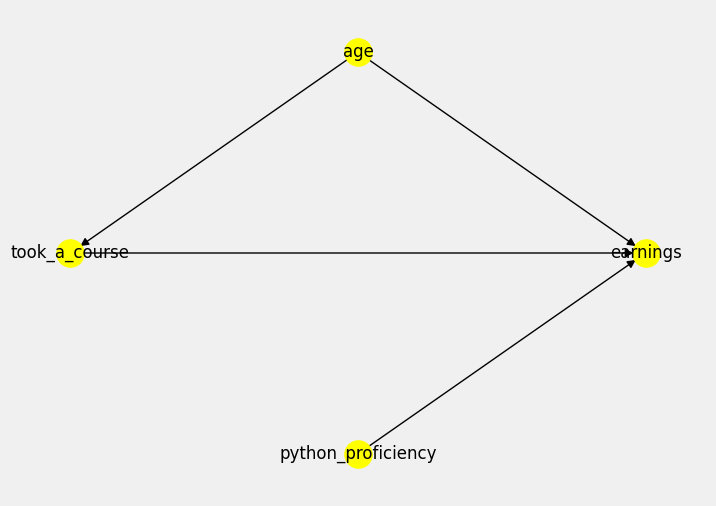

In [6]:
# Instantiate the CausalModel 
model = CausalModel(
    data=train,
    treatment='took_a_course',
    outcome='earnings',
    effect_modifiers='python_proficiency',
    graph=gml_string
)

model.view_model()

### 02. estimand

In [7]:
estimand = model.identify_effect()

print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### 03. estimate effect

In [10]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.CausalForestDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=50, max_depth=10),
            'model_t': LGBMClassifier(n_estimators=50, max_depth=10),
            'discrete_treatment': True,
            'cv': 5
        },
        'fit_params': {}
    }
)

In [11]:
estimate.cate_estimates.mean()

### Predict test

In [12]:
effect_true = test['true_effect'].values

In [13]:
from econml.dml import CausalForestDML

est = CausalForestDML(discrete_treatment=True)
est.fit(Y=train['earnings'], T=train['took_a_course'], X=train.drop(['earnings', 'took_a_course'], axis=1))
effect_pred = est.effect(test.drop(['true_effect', 'took_a_course'], axis=1))

In [14]:
mean_absolute_percentage_error(effect_true, effect_pred)

In [16]:
def plot_effect(effect_true, effect_pred, figsize=(10, 7), ylim=(5000, 22000)):
    plt.figure(figsize=figsize)
    plt.scatter(effect_true, effect_pred)
    plt.plot(np.sort(effect_true), np.sort(effect_true), alpha=.7, label='Perfect model')
    plt.xlabel('$True\ effect$', fontsize=14, alpha=.5)
    plt.ylabel('$Predicted\ effect$', fontsize=14, alpha=.5)
    plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

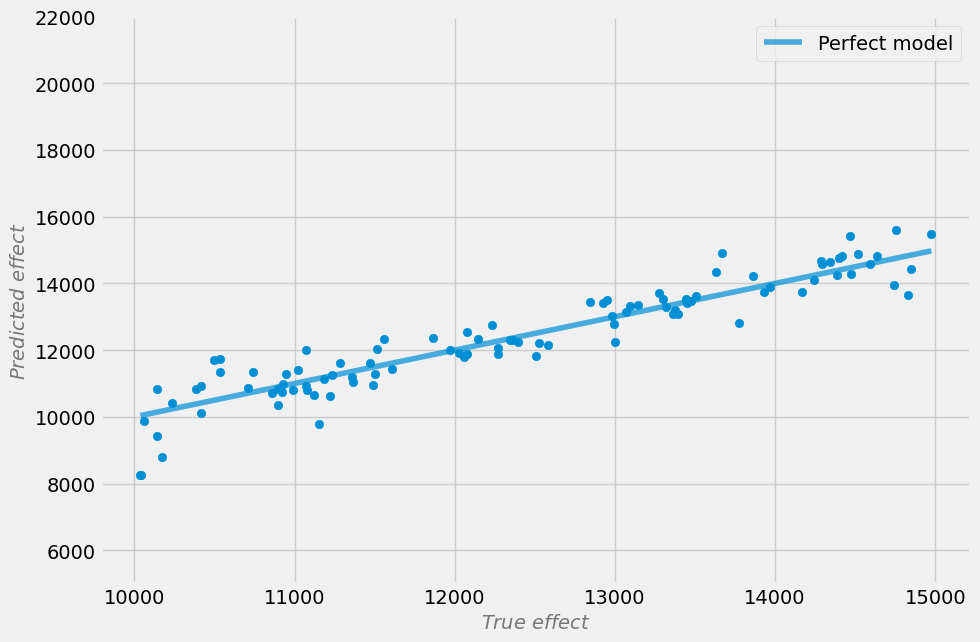

In [17]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)